In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
raw_data = pd.read_csv('Index2018.csv')

In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)

In [5]:

df_comp.set_index(df_comp.date, inplace=True)

In [6]:
df_comp.head()

,date,spx,dax,ftse,nikkei
date,,,,,
1994-01-07,1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,1994-01-13,472.47,2142.37,3360.01,18577.26


In [7]:
df_comp.drop('date', axis=1,inplace=True)

In [8]:
df_comp = df_comp.asfreq('b')

In [9]:
df_comp.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [10]:
df_comp.fillna(method='ffill',inplace=True)

In [11]:
df_comp.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


### Creating Returns 

In [12]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100


In [13]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100


### Spliting Data

In [14]:
size = int(len(df_comp)*0.8)
df,df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting Model


In [15]:
model_ar = ARIMA(df.ftse, order = (1,0,0))  #AR(1)
result_ar = model_ar.fit()

### Simple Forecast

In [16]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
date,,,,,,,,,,,,
2013-04-01,1562.173837,7795.31,6411.74,12135.02,-0.446858,0.000000,0.000000,-2.120438,-39.102169,0.000000,-0.000000,-120.310679
2013-04-02,1570.252238,7943.87,6490.66,12003.43,0.517126,1.905761,1.230867,-1.084382,45.250898,84804.471406,-785.471020,-61.526326
2013-04-03,1553.686978,7874.75,6420.28,12362.20,-1.054943,-0.870105,-1.084327,2.988896,-92.312390,-38718.796758,691.957459,169.585747
2013-04-04,1559.979316,7817.39,6344.11,12634.54,0.404994,-0.728404,-1.186397,2.203006,35.438855,-32413.252992,757.092562,124.995466
2013-04-05,1553.278930,7658.75,6249.77,12833.64,-0.429518,-2.029322,-1.487049,1.575839,-37.584791,-90302.791085,948.951813,89.410890


In [17]:
start_date = '2013-04-06'
end_date = '2013-10-01'

In [18]:
 df_pred = result_ar.predict(start= start_date, end=end_date)

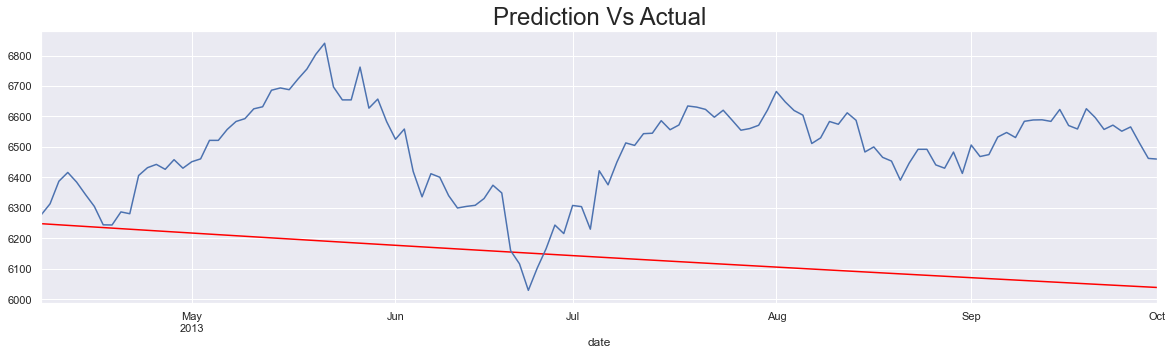

In [19]:
df_pred[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual" ,size=24)

plt.show()

### AR Model is bad against non stationary data

# Using Returns

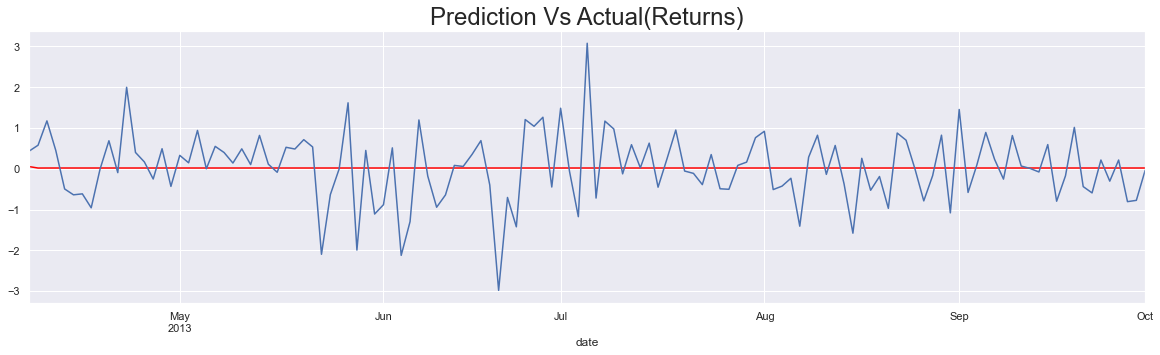

In [20]:
model_ret_ar = ARIMA(df.ret_ftse[1:], order = (1,0,0))  #AR(1)
result_ret_ar = model_ret_ar.fit()

df_pred_ret = result_ret_ar.predict(start= start_date, end=end_date)
    
df_pred_ret[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

In [21]:
result_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Wed, 18 May 2022   AIC                          15865.497
Time:                        17:33:32   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.ret_ftse    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4387           +0.0000j           43.4387            0.5000
-----------------------------------------------------------------------------
"""

## MA

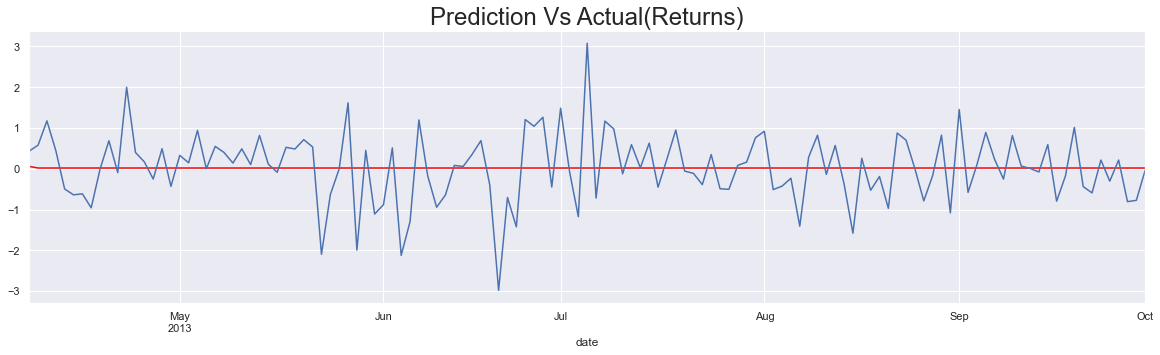

In [22]:
model_ret_ma = ARIMA(df.ret_ftse[1:], order = (0,0,1))  #AR(1)
result_ret_ma = model_ret_ma.fit()

df_pred_ma = result_ret_ma.predict(start= start_date, end=end_date)
    
df_pred_ma[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

## ARMA

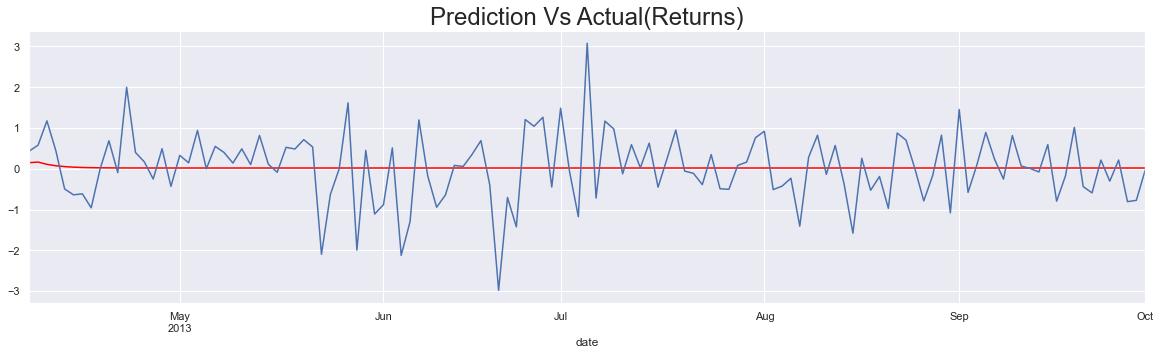

In [23]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order = (1,0,2))  #ARMA(1,0,1)
result_ret_arma = model_ret_arma.fit()

df_pred_arma = result_ret_arma.predict(start= start_date, end=end_date)
    
df_pred_arma[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

In [24]:
df_pred_arma.head()

2013-04-08    0.148299
2013-04-09    0.164511
2013-04-10    0.108732
2013-04-11    0.074322
2013-04-12    0.053093
Freq: B, dtype: float64

In [25]:
df_pred_arma.tail()

2013-09-25    0.018907
2013-09-26    0.018907
2013-09-27    0.018907
2013-09-30    0.018907
2013-10-01    0.018907
Freq: B, dtype: float64

## ARMAX

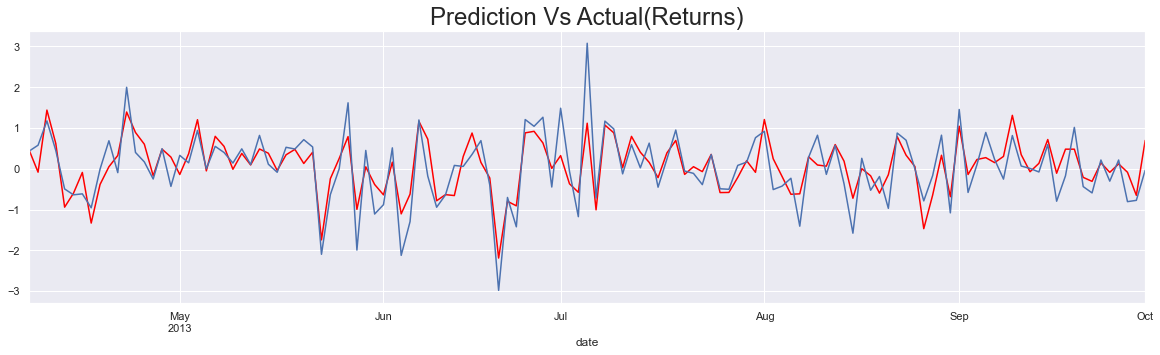

In [26]:
model_ret_armax = ARIMA(df.ret_ftse[1:],exog= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:] ,order = (1,0,1))  #ARMAX(1,0,1)
result_ret_armax = model_ret_armax.fit()

df_pred_armax = result_ret_armax.predict(start= start_date, end=end_date,
                                         exog= df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
    
df_pred_armax[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

## ARIMA

for testing purpose we need to create manually integrated series on testing set

In [27]:
df_i_test =df_test.diff(1)

In [28]:
start_date = '2013-04-08'
end_date = '2013-10-01'

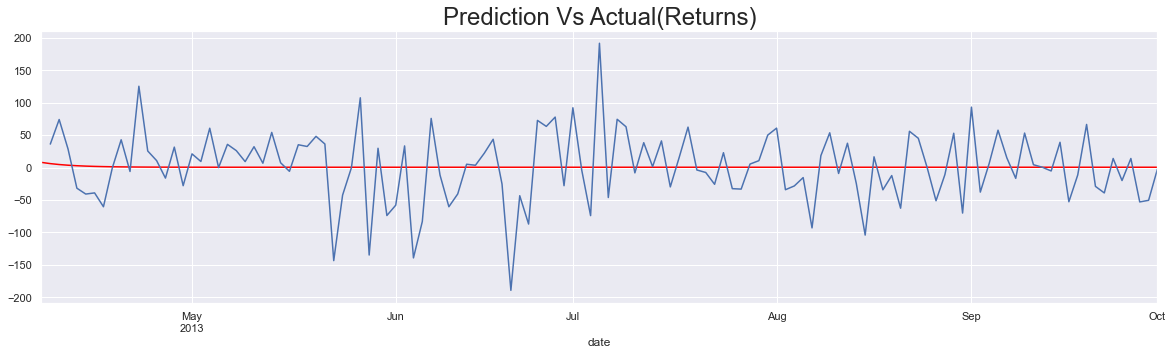

In [29]:
model_arima = ARIMA(df.ftse ,order = (1,1,1))  
result_arima = model_arima.fit()

df_pred_arima = result_arima.predict(start= start_date, end=end_date,
                                         )
    
df_pred_arima[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_i_test.ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

# SARMA

In [30]:
start_date = '2013-04-06'
end_date = '2013-10-01'

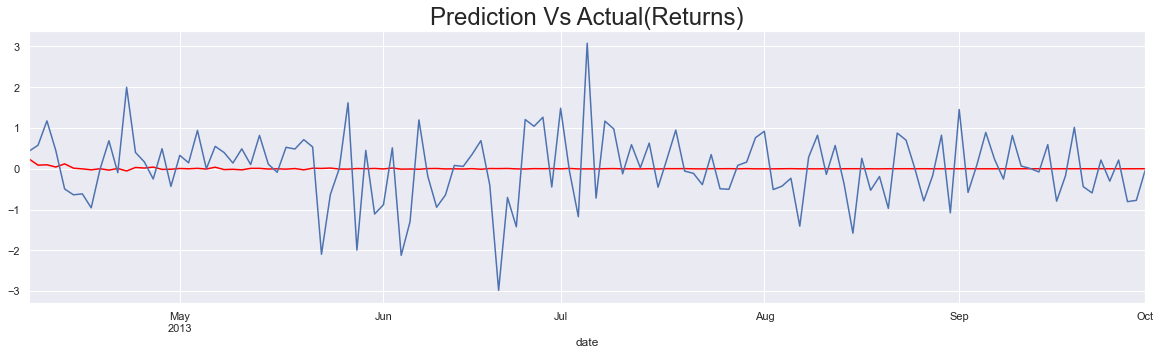

In [31]:
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order=(3,0,2,5))  #ARMA(1,0,1)
result_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = result_ret_sarma.predict(start= start_date, end=end_date)
    
df_pred_sarma[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

# SARIMAX


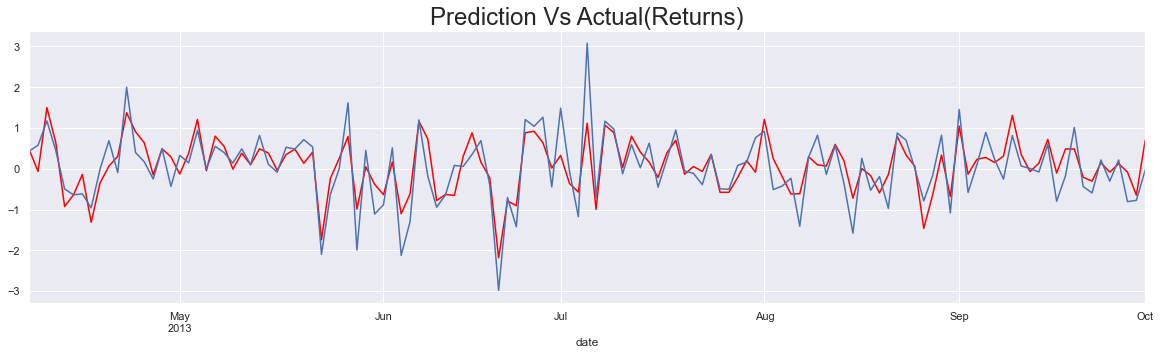

In [32]:
model_ret_sarmax = SARIMAX(df.ret_ftse[1:],exog= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], order = (3,0,4), seasonal_order=(3,0,2,5))  #ARMA(1,0,1)
result_ret_sarmax = model_ret_sarmax.fit()

df_pred_sarmax = result_ret_sarmax.predict(start= start_date, end=end_date,exog= df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date])
    
df_pred_sarmax[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Actual(Returns)" ,size=24)

plt.show()

 # Auto ARIMA

In [33]:
mode_auto = auto_arima(df.ret_ftse[1:],exogenous= df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                      m=5, max_p=5, max_q=5, max_P=5, max_Q=5)

In [35]:
df_aut_pred =pd.DataFrame(mode_auto.predict(n_periods = len(df_test[start_date:end_date]),
                          exogenous= df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]), 
                          index =df_test[start_date:end_date].index)

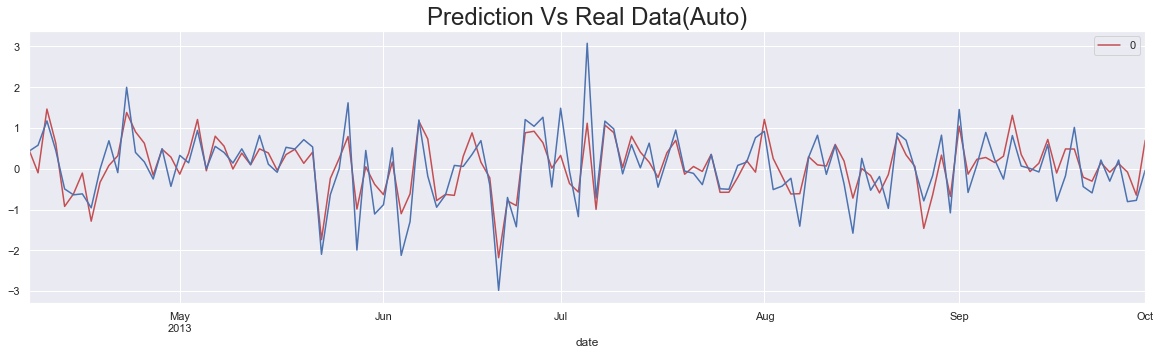

In [36]:
df_aut_pred.plot(figsize=(20,5), c='r')
df_test.ret_ftse[start_date:end_date].plot(color='b')
plt.title("Prediction Vs Real Data(Auto)" ,size=24)
plt.show()

# ARCH

In [46]:
mod_garch = arch_model(df_comp.ret_ftse[1:],vol='GARCH', p=1, q=1, mean='Constant', dist='normal')


In [47]:
res_garch = mod_garch.fit(last_obs=start_date, update_freq = 10)

Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478416067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


In [48]:
pred_garch = res_garch.forecast(horizon=1, align='target')

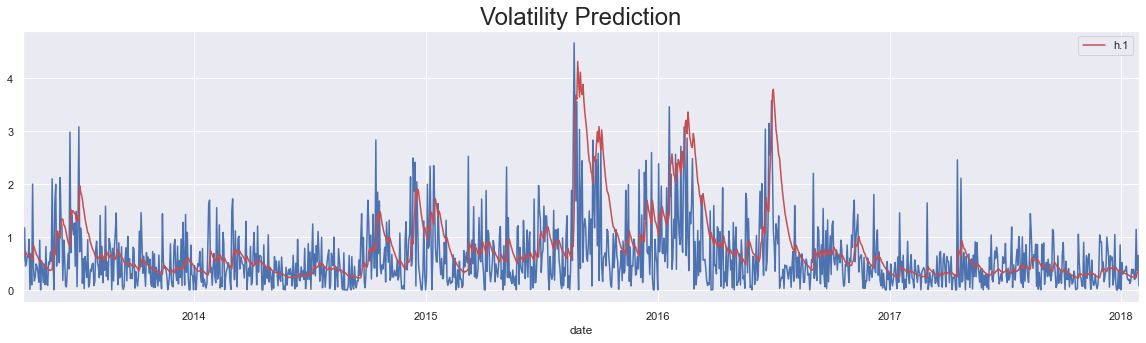

In [50]:
pred_garch.residual_variance[start_date:].plot(figsize=(20,5), c='r', zorder=2)
df_test.ret_ftse.abs().plot(color='b', zorder=1)
plt.title("Volatility Prediction", size=24)
plt.show()

In [51]:
pred_garch = res_garch.forecast(horizon=100, align='target')           # next 100 days
pred_garch.residual_variance[-1:]  

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,0.343523,0.340599,0.354857,0.25736,0.274579,0.289542,0.300044,0.309239,0.313105,0.329072,...,0.924115,0.92664,0.944064,0.963335,0.981329,0.993313,0.958609,0.915886,0.925796,0.938776


# Multi Regression Model

In [52]:
from statsmodels.tsa.api import VARre

In [53]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_nikkei', 'ret_ftse']][1:]

In [54]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
result_var_ret = model_var_ret.fit(ic = 'aic')

In [55]:
result_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, May, 2022
Time:                     18:44:27
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.475578
Nobs:                     5015.00    HQIC:                  0.404637
Log likelihood:          -29298.6    FPE:                    1.44248
AIC:                     0.366366    Det(Omega_mle):         1.41857
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.035821         0.017035            2.103           0.035
L1.ret_spx           -0.112626         0.018130           -6.212           0.000
L1.ret_dax            0.065624         0.019491           

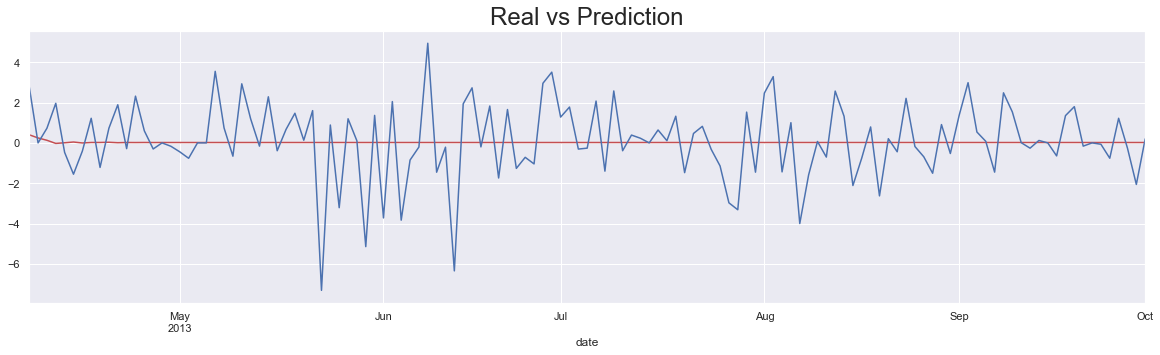

In [59]:
lag_order_ret = result_var_ret.k_ar
var_pred_ret = result_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data=var_pred_ret, index=df_test[start_date:end_date].index,
                          columns=df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize=(20,5), color='r')

df_test.ret_nikkei[start_date:end_date].plot(c='b')
plt.title("Real vs Prediction", size=24)
plt.show()

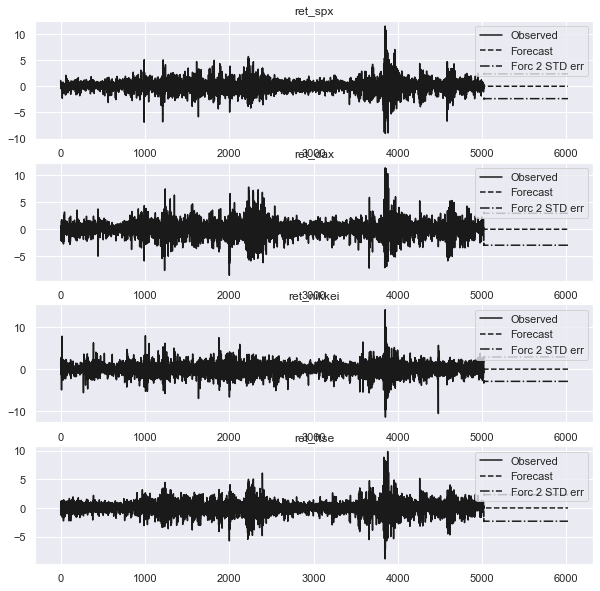

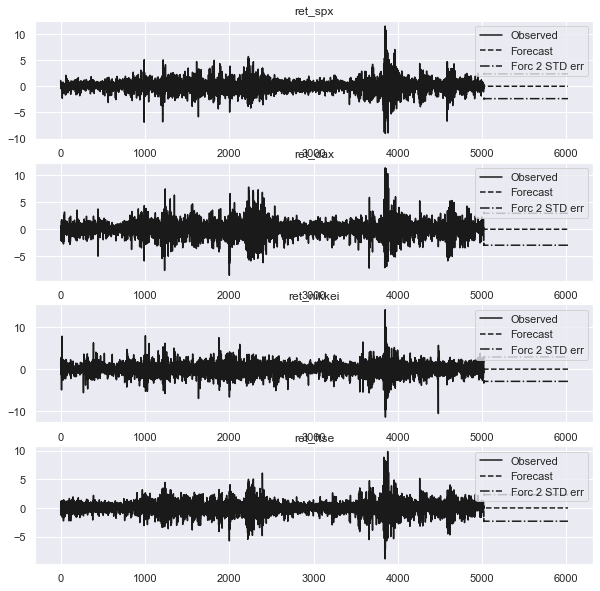

In [60]:
result_var_ret.plot_forecast(1000)